In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow import keras

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.preprocessing import PolynomialFeatures

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.metrics import AUC # Area under the curve, default: ROC
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, LearningRateScheduler
import kerastuner as kt

In [43]:
def replace_outliers_zeros(data_frame, outlayers_keys: dict, zero_keys: list, mean_median = False, data_to_replace = None):
    """
    Fuction to replace outliers from data_frame
    and replace them with median or mean value
    Don't afect the original data frame, returns a copy 
    with the parameters changed
    """
    data = data_frame.copy()
    if len(zero_keys) != 0:
        for key in zero_keys:
            data.loc[data[key] == 0, key] = np.NaN
            
    replace = {}
    if not data_to_replace:
        for x in data.keys():
            if mean_median:
                replace[x] = np.mean(data[x].dropna())
            else:
                replace[x] = np.median(data[x].dropna())
    else:
        replace = data_to_replace.copy()
        
    for key, val in outlayers_keys.items():
        data.loc[data[key] < val[0], key] = np.NaN
        data.loc[data[key] > val[1], key] = np.NaN
    
    for key, val in replace.items():
        data[key] = data[key].replace(np.NaN, replace[key])
        
    return data, replace


def normalize(data_frame, data_to_norm=None):
    data = data_frame.copy()
    norm_std = {}
    if not data_to_norm:
        for key in data:
            k_mean = np.mean(data[key])
            k_std = np.std(data[key])
            norm_std[key] = [k_mean, k_std]
    else:
        norm_std = data_to_norm.copy()
        
    for key in data:
        data[key] = (data[key]-norm_std[key][0])/norm_std[key][1]
        
    return data, norm_std

def metrics(tn, fp, fn, tp):
    spec = tn / (tn + fp + 1e-15)
    neg_pred_val = tn / (tn + fn + 1e-15)
    sens = tp / (tp + fn + 1e-15)
    pos_pred_val = tp / (tp + fp + 1e-15)
    #print('\tEspecificidad: {}\n\tSesitividad: {}\n\tValor predictivo positivo: {}\n\tValor predictivo negativo: {}'.format(spec, 
    #                                                                                                                sens, 
    #                                                                                                                neg_pred_val, 
    #                                                                                                                pos_pred_val))
    return spec, sens, neg_pred_val, pos_pred_val
    
def print_metrics(y, y_pred, plot_n, label):
    fpr, tpr, th = roc_curve(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    plt.subplot(1, 2, plot_n)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC={}'.format(roc_auc))
    plt.title('ROC Curve {}'.format(label))
    #plt.show()
    #print('PRINCIPAL\n\tArea bajo la curva ROC: {}\nSECUNDARIAS'.format(roc_auc))
    tn, fp, fn, tp = confusion_matrix(y, np.rint(y_pred)).ravel()
    spec, sens, neg_pred_val, pos_pred_val = metrics(tn, fp, fn, tp)
    return roc_auc, spec, sens, neg_pred_val, pos_pred_val
    
    
def verify_model(my_model, x_train, y_train, x_validation, y_validation):
    #print('Sobre train')
    y_train_pred = my_model.predict(x_train)
    y_valid_pred = my_model.predict(x_validation)
    #plt.figure(1)
    #rt, spt, snt, npt, ppt = print_metrics(y_train, y_train_pred)
    #rv, spv, snv, npv, ppv = print_metrics(y_validation, y_valid_pred)
    #print('Sobre validation')
    #print('\t\t\tTrain\t\t\tValidation')
    #print('AUC ROC: {}\t\t\t{}'.format(rt,rv))
    #print('Especif: {}\t\t\t{}'.format(spt,spv))
    #print('Sens: {}\t\t\t{}'.format(snt,snv))
    #print('Val. pred. positivo: {}\t\t\t{}'.format(ppt,ppv))
    #print('Val. pred. neg: {}\t\t\t{}'.format(npt,npv))
    return y_train_pred, y_valid_pred

def run_tunner(name, model_builder, x_train, y_train, x_validation, y_validation, my_callbacks=[]):
    hyptester = kt.Hyperband(model_builder, 
                             kt.Objective('val_auc', direction='max'), 
                             max_epochs=15, 
                             factor=3,
                             project_name=name,
                             directory='D:/Documents/Keras/models'
                            )
    hyptester.search(x_train, y_train, 
                     epochs=50, 
                     validation_data=(x_validation, y_validation))
    
    hyperparams = hyptester.get_best_hyperparameters(num_trials=2)[0]
    best = hyptester.hypermodel.build(hyperparams)
    history = best.fit(x_train, y_train, epochs=100,
                       validation_data=(x_validation, y_validation), verbose=0,
                       callbacks=my_callbacks)
    return best, history, hyperparams

In [5]:
df = pd.read_csv('../../databases/diabetes.csv')

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Tomando el EDA del Tp1, se reemplazan los valores no medidos por NaN y se quitan los outlayers para luego reemplazarlos por la media o la mediana

In [7]:
outlayers = {
    'BloodPressure': (40, np.Inf),
    'SkinThickness': (0, 80),
    'Insulin': (0, 400),
    'BMI': (0, 50)
}

zeros = [
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI'
]

In [8]:
x_data = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
y_data = df['Outcome']

In [9]:
# Split dataset into 15% test, 85% train 
x, x_test, y, y_test = train_test_split(x_data, y_data, test_size=0.15)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.15)

In [10]:
print('shape train {}, {} '.format(x_train.shape, y_train.shape))
print('shape valid {}, {} '.format(x_valid.shape, y_valid.shape))
print('shape test {}, {} '.format(x_test.shape, y_test.shape))

shape train (554, 8), (554,) 
shape valid (98, 8), (98,) 
shape test (116, 8), (116,) 


In [11]:
x_train_clean, _data = replace_outliers_zeros(x_train, outlayers, zeros, mean_median=True)
x_test_clean, _data = replace_outliers_zeros(x_test, outlayers, zeros, mean_median=True, data_to_replace=_data)
x_valid_clean, _data = replace_outliers_zeros(x_valid, outlayers, zeros, mean_median=True, data_to_replace=_data)

In [12]:
x_train_clean, _norm_dict = normalize(x_train_clean, None)
x_valid_clean, _norm_dict = normalize(x_valid_clean, _norm_dict)
x_test_clean, _norm_dict = normalize(x_test_clean, _norm_dict)

In [13]:
x_train_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02,5.540000e+02
mean,-2.985979e-17,6.876770e-16,-7.266550e-16,1.585575e-15,-1.610164e-14,5.500414e-15,-6.056627e-16,1.470945e-16
std,1.000904e+00,1.000904e+00,1.000904e+00,1.000904e+00,1.000904e+00,1.000904e+00,1.000904e+00,1.000904e+00
min,-1.149241e+00,-2.598999e+00,-2.781014e+00,-2.555599e+00,-2.482275e+00,-2.185488e+00,-1.143283e+00,-1.035549e+00
25%,-8.532487e-01,-7.317017e-01,-7.528144e-01,-3.966172e-01,-3.674703e-01,-7.314707e-01,-6.624798e-01,-7.852094e-01
50%,-2.612640e-01,-9.815436e-02,-2.569063e-02,1.704499e-15,2.058110e-01,2.867228e-02,-3.025974e-01,-3.679775e-01
75%,6.267130e-01,6.354267e-01,5.993189e-01,3.230436e-01,2.058110e-01,6.640738e-01,3.711024e-01,6.333792e-01
max,3.882629e+00,2.502724e+00,4.148669e+00,4.041291e+00,4.576410e+00,2.772983e+00,5.599474e+00,3.971235e+00


In [48]:
poly_order = 10

In [49]:
pyly_score = {}

for i in range(2,poly_order):
    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train_clean)
    pol_x_valid = poly.fit_transform(x_valid_clean)
        
    def model_builder(hp):
        model = Sequential()
        model.add(Dense(units=1, activation='sigmoid', input_shape=(pol_x_train.shape[1],)))

        # Optimizadores a porbar
        optimizer_type = hp.Choice('optimizer_type', values=['SGD', 'Adam']) 
        # Hyperparametros para porbar en el optimizador
        _learning_rate_ = hp.Float('learning_rate', min_value=1e-3, max_value=3.3, sampling='LOG')
        _momentum_ = hp.Choice('momentum', values=[0.5, 0.75, 0.85, 0.9, 0.99, 0.999])

        if optimizer_type == 'SGD':
            _optimizer_ = SGD(learning_rate=_learning_rate_, momentum=_momentum_)
        else:
            _optimizer_ = Adam(learning_rate=_learning_rate_)

        _metrics_ = [AUC()]
        _loss_ = BinaryCrossentropy(from_logits=True)

        model.compile(optimizer=_optimizer_,
                      loss=_loss_,
                      metrics=_metrics_)
    
        return model
    
    best_model, hist, hyperparams = run_tunner("feature_poly_{}".format(i), model_builder, pol_x_train, y_train, pol_x_valid, y_valid)
    a, b = verify_model(best_model, pol_x_train, y_train, pol_x_valid, y_valid)
    pyly_score[i] = [a, b]

Trial 30 Complete [00h 00m 03s]
val_auc: 0.8261648416519165

Best val_auc So Far: 0.8349014520645142
Total elapsed time: 00h 01m 16s
INFO:tensorflow:Oracle triggered exit


ORDEN 2


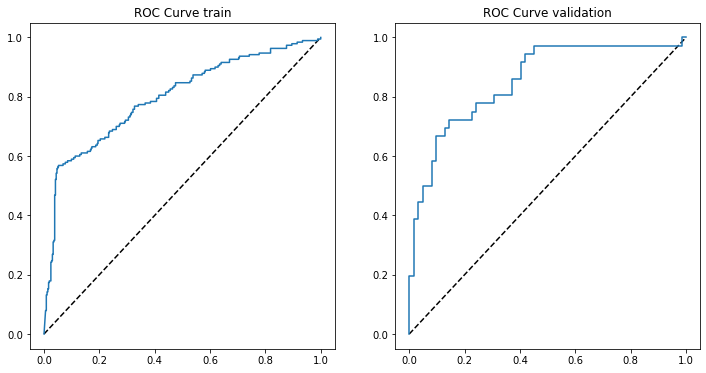

			Train			Validation
AUC ROC: 		0.7976431463273568	0.8539426523297491
Especif: 		0.9532967032967034	0.9193548387096774
Sens: 			0.5421052631578948	0.5833333333333334
Val. pred. positivo: 	0.8583333333333333	0.8076923076923077
Val. pred. neg: 	0.7995391705069125	0.7916666666666666
ORDEN 3


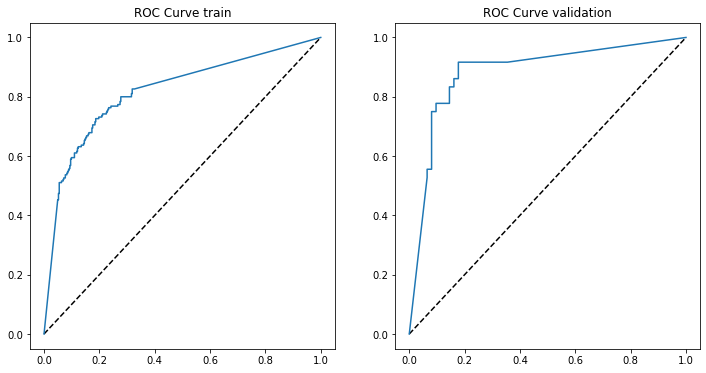

			Train			Validation
AUC ROC: 		0.8169968189705032	0.8839605734767024
Especif: 		0.945054945054945	0.9193548387096774
Sens: 			0.5105263157894737	0.5555555555555556
Val. pred. positivo: 	0.8290598290598291	0.8
Val. pred. neg: 	0.7871853546910755	0.7808219178082192
ORDEN 4


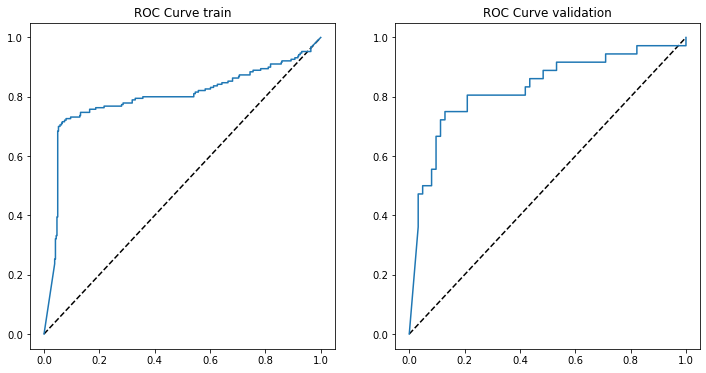

			Train			Validation
AUC ROC: 		0.7965008675534992	0.8301971326164873
Especif: 		0.9505494505494505	0.9032258064516129
Sens: 			0.6789473684210526	0.6666666666666666
Val. pred. positivo: 	0.8775510204081632	0.8
Val. pred. neg: 	0.8501228501228502	0.8235294117647058
ORDEN 5


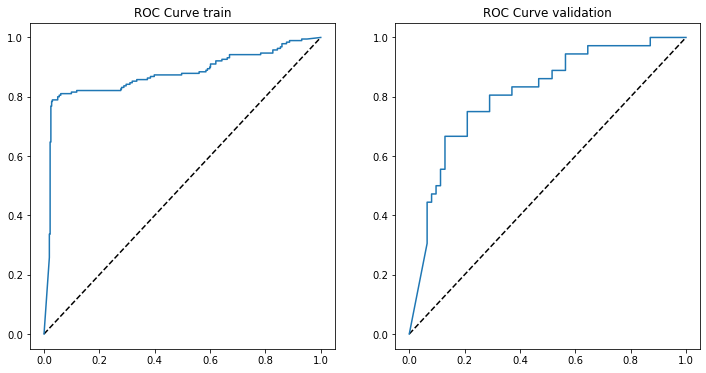

			Train			Validation
AUC ROC: 		0.8743131868131867	0.8109318996415771
Especif: 		0.9752747252747253	0.8709677419354839
Sens: 			0.7578947368421053	0.5555555555555556
Val. pred. positivo: 	0.9411764705882353	0.7142857142857143
Val. pred. neg: 	0.885286783042394	0.7714285714285715
ORDEN 6


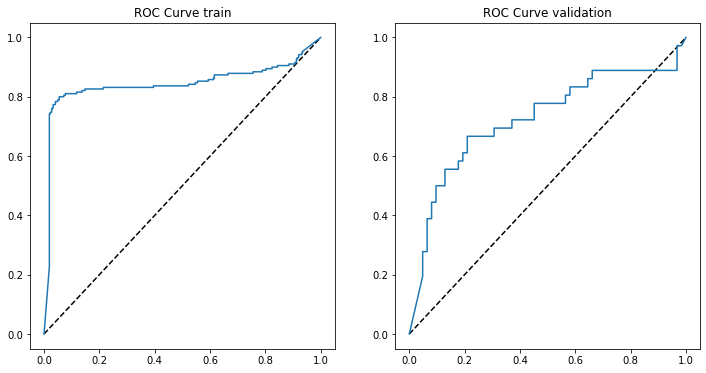

			Train			Validation
AUC ROC: 		0.8444548872180452	0.724910394265233
Especif: 		0.9807692307692307	0.9032258064516129
Sens: 			0.7105263157894737	0.4722222222222222
Val. pred. positivo: 	0.9507042253521126	0.7391304347826086
Val. pred. neg: 	0.866504854368932	0.7466666666666667
ORDEN 7


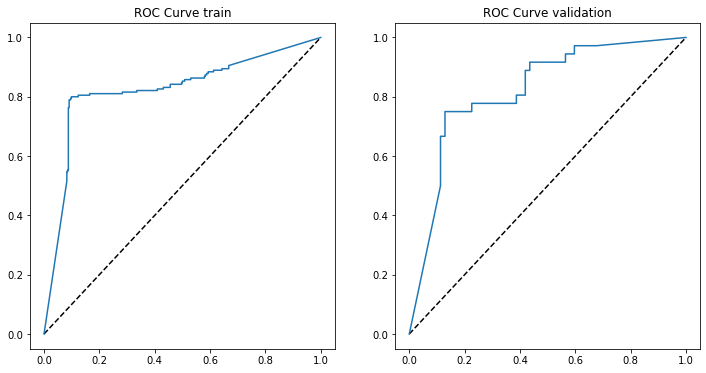

			Train			Validation
AUC ROC: 		0.8241035280508966	0.8225806451612904
Especif: 		0.9093406593406593	0.8387096774193549
Sens: 			0.7789473684210526	0.75
Val. pred. positivo: 	0.8176795580110497	0.7297297297297297
Val. pred. neg: 	0.8873994638069705	0.8524590163934426
ORDEN 8


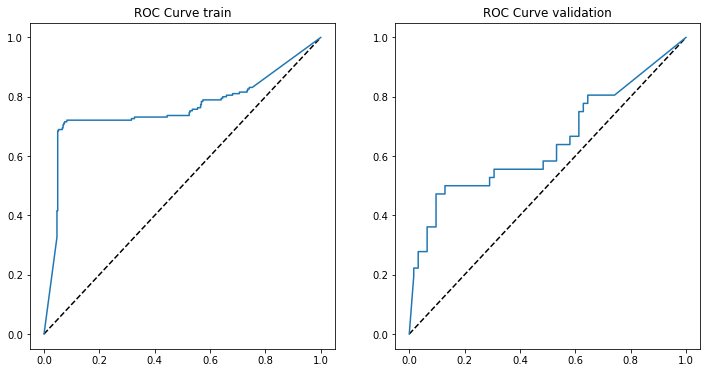

			Train			Validation
AUC ROC: 		0.7608733371891266	0.6449372759856632
Especif: 		0.9505494505494505	0.9354838709677419
Sens: 			0.6631578947368421	0.3611111111111111
Val. pred. positivo: 	0.875	0.7647058823529411
Val. pred. neg: 	0.8439024390243902	0.7160493827160493
ORDEN 9


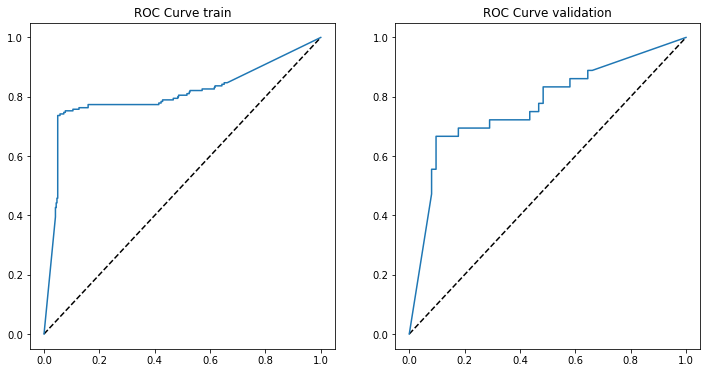

			Train			Validation
AUC ROC: 		0.8057258530942741	0.7721774193548387
Especif: 		0.9505494505494505	0.9032258064516129
Sens: 			0.7157894736842105	0.6388888888888888
Val. pred. positivo: 	0.8831168831168831	0.7931034482758621
Val. pred. neg: 	0.865	0.8115942028985508


In [50]:
for i in range(2,poly_order):
    print('ORDEN {}'.format(i))
    train_pred, valid_pred = pyly_score[i]
    plt.figure(1, figsize=[12,6])
    rt, spt, snt, npt, ppt = print_metrics(y_train, train_pred, 1, 'train')
    rv, spv, snv, npv, ppv = print_metrics(y_valid, valid_pred, 2, 'validation')
    plt.show()
    #print('Sobre validation')
    print('\t\t\tTrain\t\t\tValidation')
    print('AUC ROC: \t\t{}\t{}'.format(rt,rv))
    print('Especif: \t\t{}\t{}'.format(spt,spv))
    print('Sens: \t\t\t{}\t{}'.format(snt,snv))
    print('Val. pred. positivo: \t{}\t{}'.format(ppt,ppv))
    print('Val. pred. neg: \t{}\t{}'.format(npt,npv))
    

Utilizando orden 7 que es el mejor, vamos a porbar las diversar regularizaciones